In [1]:
# PYTHONPATH settings
import sys
sys.path.append("/home/jovyan/lib") 

In [2]:
from mundilib import mundiCatalogue

# other tools
import os
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

### Treatment of an in-memory image - not saved on disk (display/make histogram/add mask, ...)

In [3]:
# getting image from Mundi
c = mundiCatalogue()
wms = c.getCollection("Sentinel2").mundi_wms()

response = wms.getmap(layers=['92_NDWI'],
                     srs='EPSG:3857',
                     bbox=(146453.3462,5397218.5672,176703.3001,5412429.5358), # Toulouse
                     size=(600, 300),
                     format='image/png',
                     time='2018-04-21/2018-04-21',
                     showlogo=False,
                     transparent=False)

In [4]:
# writing image
#out = open(image_file, 'wb')     
#out.write(response.read())
#out.close()

In [5]:
# reading bytes stream through a virtual memory file - no need to save image on disk
data = response.read()
vsipath = '/vsimem/img'
gdal.FileFromMemBuffer(vsipath, data)
raster_ds = gdal.Open(vsipath)
print (type(raster_ds))

# Projection
print ("Projection: ", format(raster_ds.GetProjection()))

# Dimensions
print ("X: ", raster_ds.RasterXSize)
print ("Y: ", raster_ds.RasterYSize)

# Number of bands
print ("Nb of bands: ", raster_ds.RasterCount)

# band informations
print ("Bands information:")
for band in range(raster_ds.RasterCount):
    band += 1
    srcband = raster_ds.GetRasterBand(band)
    if srcband is None:
        continue
    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue
    print (" - band #%d : Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                band, stats[0], stats[1], stats[2], stats[3] ))

<class 'osgeo.gdal.Dataset'>
Projection:  
X:  600
Y:  300
Nb of bands:  3
Bands information:
 - band #1 : Minimum=40.000, Maximum=255.000, Mean=157.742, StdDev=43.432
 - band #2 : Minimum=43.000, Maximum=255.000, Mean=204.927, StdDev=25.750
 - band #3 : Minimum=40.000, Maximum=255.000, Mean=159.646, StdDev=43.093


In [6]:
# Getting first band of the raster as separate variable
band1 = raster_ds.GetRasterBand(1)  
    
# Check type of the variable 'band'
print (type(band1))

# Data type of the values
gdal.GetDataTypeName(band1.DataType)

<class 'osgeo.gdal.Band'>


'Byte'

In [7]:
# getting array from band dataset
band1_ds = band1.ReadAsArray()

# The .ravel method turns an 2-D numpy array into a 1-D vector
print (band1_ds.shape)
print (band1_ds.ravel().shape)

# Print only selected metadata:
print ("No data value :", band1.GetNoDataValue()) # none
print ("Min value     :", band1.GetMinimum())
print ("Max value     :", band1.GetMaximum())

# Compute statistics if needed
if band1.GetMinimum() is None or band1.GetMaximum()is None:
    band1.ComputeStatistics(0)
    print("Statistics computed.")

# Fetch metadata for the band
band1.GetMetadata()

(300, 600)
(180000,)
No data value : None
Min value     : 40.0
Max value     : 255.0


{'STATISTICS_APPROXIMATE': 'YES',
 'STATISTICS_MAXIMUM': '255',
 'STATISTICS_MEAN': '157.74231481481',
 'STATISTICS_MINIMUM': '40',
 'STATISTICS_STDDEV': '43.432474049368'}

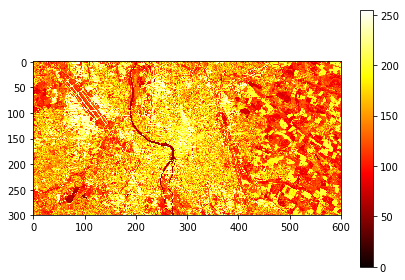

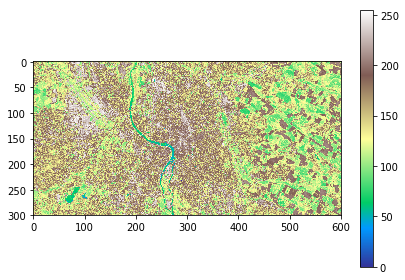

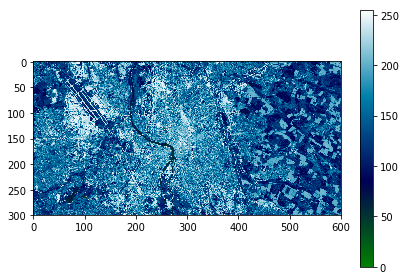

In [8]:
# see cmap values:
# cf. https://matplotlib.org/examples/color/colormaps_reference.html

for c in ["hot", "terrain", "ocean"]:
    plt.imshow(band1_ds, cmap = c, interpolation='nearest')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

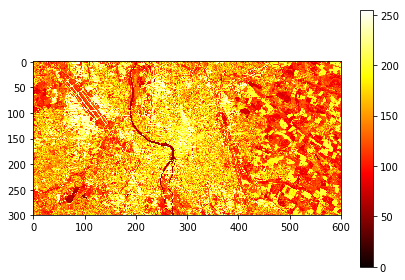


--- raster content (head) ---
[[138 152 156 ... 194 193 111]
 [133 173 154 ... 202 119 111]
 [141 165 144 ... 109 152 121]
 ...
 [163 206 139 ... 207 211 205]
 [159 171 202 ... 204 207 207]
 [150 144 136 ... 201 202 208]]


In [9]:
plt.imshow(band1_ds, cmap = "hot", interpolation='nearest')
plt.colorbar()
plt.tight_layout()
plt.show()

print ("\n--- raster content (head) ---")
print (band1_ds[1:10, ])

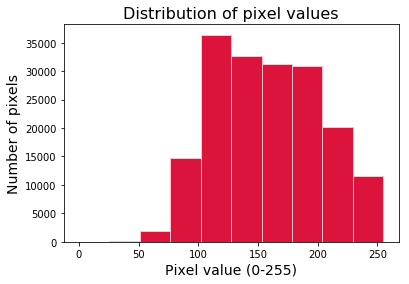

In [10]:
band1_hist_ds = band1_ds.ravel()
band1_hist_ds = band1_hist_ds[~np.isnan(band1_hist_ds)]

# 1 column, 1 line
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.hist(band1_hist_ds, bins=10, histtype='bar', color='crimson', ec="pink")
#axes.hist(lidar_dem_hist, bins=[0, 25, 50, 75, 100, 150, 200, 255], histtype='bar', color='crimson', ec="pink")
axes.set_title("Distribution of pixel values", fontsize=16)
axes.set_xlabel('Pixel value (0-255)', fontsize=14)
axes.set_ylabel('Number of pixels', fontsize=14)  
#axes.legend(prop={'size': 10})

plt.show()

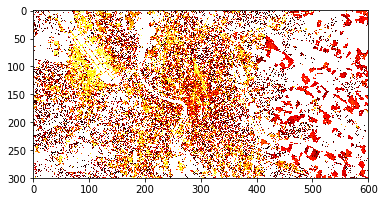

In [11]:
# masking some pixels
masked_array = np.ma.masked_where(band1_ds<170, band1_ds)
plt.imshow(masked_array, cmap="hot", interpolation='nearest')
plt.show()

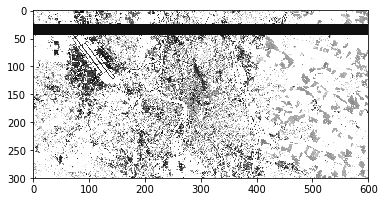

In [12]:
# adding of a line on image mask, changing pixel value with mask
masked_array[25:45,:] = 250
plt.imshow(masked_array, cmap="binary")
plt.show()